In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from tqdm import tqdm
import numba as nb
import math
from prettytable import PrettyTable
from scipy.optimize import curve_fit
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

In [3]:
import mpmath as mp
mp.dps=10
# para_in = 'theta'
para_in = 'T'

def Un_nonvec(u,kappa,n):
    if para_in == 'theta':
        theta = np.sqrt(2)
    elif para_in == 'T':
        theta = np.sqrt(2.0-3.0/kappa)
    zeta = u/theta
    fac1= (1j/2)**(n+1)
    fac2= np.math.factorial(n)*sp.gamma(2*kappa+n)*sp.gamma(kappa+1)/kappa**(1.5+n/2)/sp.gamma(2*kappa-1)/sp.gamma(kappa+1+n)
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(1+n,2*kappa+n,kappa+1+n,z))
    return (fac1*fac2*hyp).real

def B_kappa_nonvec(u,kappa):
    if para_in == 'theta':
        theta = np.sqrt(2)
    elif para_in == 'T':
        theta = np.sqrt(2.0-3.0/kappa)
    zeta = u/theta
    fac = (kappa-0.5) / kappa / (kappa+1.0)
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(2,2*kappa+1,kappa+2,z))
    return 1.0/theta**2*fac*hyp.real

def D_kappa_nonvec(u,kappa):
    if para_in == 'theta':
        theta = np.sqrt(2)
    elif para_in == 'T':
        theta = np.sqrt(2.0-3.0/kappa)
    zeta = u/theta
    fac = 1.5 * (kappa-0.5) * (kappa+0.5) / kappa**2 / (kappa+2.0) / (kappa+3.0) / theta**4
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(4,2*kappa+3,kappa+4,z))
    return fac*hyp.real

Un = np.vectorize(Un_nonvec)
B_kappa = np.vectorize(B_kappa_nonvec)
D_kappa = np.vectorize(D_kappa_nonvec)

In [22]:
u = 1.0
kappa = 8.0
theta = np.sqrt(2.0-3.0/kappa)
delta = 15.0

L = 6*delta
vmax = 15 # 速度最大值
nx = 2000
nv = 140000
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)

In [23]:
psi_list = 10**np.linspace(-3,-1,num=7)
print(psi_list)

[0.001      0.00215443 0.00464159 0.01       0.02154435 0.04641589
 0.1       ]


In [24]:
dpsi_l = []
ddelta_l = []

for psi in tqdm(psi_list):
    xp = (x-L/2)/delta
    phi = 0.9*psi*np.cosh(xp)**(-2)

    # for the given $\psi$ and $\Delta$, first calculate the derivatives of $f_t$
    dft_dx = (4.0/delta**2 - B_kappa(u,kappa))/np.pi
    d3ft_dx3 = 4*(-6.0/psi/delta**2 - D_kappa(u,kappa))/np.pi

    #then, construct the suitable $f_t$ with the shifted kappa distrubiton as $f_u$
    @nb.jit
    def nonvec_f_fun_sech2(v,phi):
        r = 0
        v_waveframe = v
        w = (v_waveframe**2)/2-phi
        kt2 = kappa*theta**2
        fac = math.gamma(kappa)/math.gamma(kappa-0.5)/(math.pi*kt2)**0.5
        if w>0:
            if v_waveframe<=-(2*phi)**0.5:
                r=fac*(1+(-(2*w)**0.5+u)**2/kt2)**(-kappa)
            elif v_waveframe>(2*phi)**0.5:
                r=fac*(1+( (2*w)**0.5+u)**2/kt2)**(-kappa)
        else:
            r=fac*(1+u**2/kt2)**(-kappa) * (1-w * (2*kappa/(kt2+u**2)) * (1-2*(kappa+1)*u**2/(kt2+u**2)) ) + dft_dx*(-2*w)**0.5 + d3ft_dx3*(-2*w)**1.5/6
        return r
    f_fun_sech2 = np.vectorize(nonvec_f_fun_sech2)
    
    #find the self-consistent solution of the distributions $f_t$ and $f_u$
    for count in range(6):
        V,Phi=np.meshgrid(v,phi)
        f_matrix = f_fun_sech2(V,Phi)
        n_vector = f_matrix.sum(axis=1)*dv

        dx2 = dx*dx
        laplace = -2.0*np.eye(nx-2,k=0)+np.eye(nx-2,k=1)+np.eye(nx-2,k=-1)
        r = (1.0 - n_vector[1:nx-1])*dx2 + np.dot(laplace,phi[1:nx-1])

        m = 2.0 + (n_vector[2:nx]-n_vector[0:nx-2])/(phi[2:nx]-phi[0:nx-2])*dx2
        nr_mat = np.diag(m) - np.eye(nx-2,k=1) - np.eye(nx-2,k=-1)
        dphi = np.linalg.solve(nr_mat,r)
        phi[1:nx-1] += dphi

        err = ((dphi/phi[1:nx-1])**2).sum()
        if err<= 1e-6:
            break
    if err>= 1e-3:
        print('delta',delta)
        print('psi',psi)

    def phi2_theo(x,a,da):
        xp = (x-L/2)/da
        return a*np.cosh(xp)**(-2)
    
    #fit the numerical self-consistent potential with $\phi_{num} = \psi_{num} \sech^2 (x/\Delta_{num})$
    para2,pcov=curve_fit(phi2_theo,x,phi)
    Ddelta = round(abs(para2[1]-delta)/para2[1]*100,2)
    Dpsi = round(abs(para2[0]-psi)/para2[0]*100,2)  

    dpsi_l.append(Dpsi)
    ddelta_l.append(Ddelta)

100%|████████████████████████████████████████████████████████████████████████████████| 7/7 [2:06:30<00:00, 1084.42s/it]


In [25]:
#delta=5
# psi_err_1 = np.array(dpsi_l)
# delta_err_1 = np.array(ddelta_l)
#delta=10
# psi_err_2 = np.array(dpsi_l)
# delta_err_2 = np.array(ddelta_l)
#delta=15
psi_err_3 = np.array(dpsi_l)
delta_err_3 = np.array(ddelta_l)

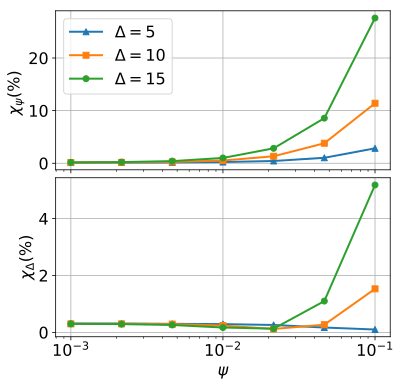

In [33]:
fig = plt.figure(figsize=(6,6))

psi_ticks = 10**np.linspace(-3,-1,num=3)

ax1 = plt.subplot(211)
ax1.plot(psi_list,psi_err_1,marker='^',label=r'$\Delta=5$')
ax1.plot(psi_list,psi_err_2,marker='s',label=r'$\Delta=10$')
ax1.plot(psi_list,psi_err_3,marker='o',label=r'$\Delta=15$')
# ax1.text(1e-3,2,r'$\Delta=5$')
ax1.set_xscale('log')
ax1.set_ylabel(r'$\chi_\psi(\%)$ ')
ax1.grid()
ax1.legend()
plt.xticks(psi_ticks,[])

ax2 = plt.subplot(212)
ax2.plot(psi_list,delta_err_1,marker='^',label=r'$\Delta=5$')
ax2.plot(psi_list,delta_err_2,marker='s',label=r'$\Delta=10$')
ax2.plot(psi_list,delta_err_3,marker='o',label=r'$\Delta=15$')
ax2.set_xscale('log')
ax2.set_ylabel(r'$\chi_\Delta (\%)$')
ax2.grid()
plt.xticks(psi_ticks)
ax2.set_xlabel(r'$\psi$')

plt.subplots_adjust(hspace = 0.05,wspace=0.26)
# plt.savefig('../1-submit to pop/1-resubmission/verification_err2.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

In [27]:
print('psi  ',psi_err_1)
print('delta',delta_err_1)

psi   [0.13 0.14 0.16 0.23 0.43 1.04 2.84]
delta [0.31 0.31 0.3  0.29 0.26 0.17 0.1 ]


In [28]:
print('psi  ',psi_err_2)
print('delta',delta_err_2)

psi   [ 0.14  0.17  0.25  0.52  1.33  3.8  11.4 ]
delta [0.3  0.3  0.29 0.24 0.12 0.27 1.53]


In [29]:
print('psi  ',psi_err_3)
print('delta',delta_err_3)

psi   [ 0.16  0.22  0.41  1.01  2.84  8.57 27.59]
delta [0.3  0.29 0.26 0.17 0.13 1.1  5.18]
